<a href="https://colab.research.google.com/github/FarahZayed/Qr-detector/blob/master/team_14_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **import** **libraries**

In [ ]:
!pip install --upgrade reedsolo
import reedsolo as rs

In [ ]:
import cv2
import reedsolo
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image, ImageFilter
import math
from matplotlib import pyplot as plt
from skimage import io, color, filters, feature
from math import sqrt
from scipy.ndimage import binary_opening

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read the image

In [ ]:
#insert the path of the image
img = cv2.imread("/content/drive/MyDrive/testcases/01-Getting-started.png", cv2.IMREAD_GRAYSCALE)

#  Function ma7tgnha

In [ ]:
def angle_ABC(a, b, c):
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def find_bad_dists(hull, distance = 10):
    mask = []
    points, _, _ = hull.shape
    for i in range(points):
        ai = i
        bi = (i+1)%points
        x1 = hull[ai][0][0]
        y1 = hull[ai][0][1]
        x2 = hull[bi][0][0]
        y2 = hull[bi][0][1]


        dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 )
        if dist < distance:
            mask.append(bi)
    return mask



def find_bad_angles(hull, acute_angle = 30, obtuse_angle = 140):
    mask = []
    points, _, _ = hull.shape
    for i in range(points):
        ai = i
        bi = (i+1)%points
        ci = (i+2)%points

        a = hull[ai][0]
        b = hull[bi][0]
        c = hull[ci][0]
        angle = angle_ABC(a, b, c)
        if angle > obtuse_angle or angle < acute_angle:
            mask.append(bi)
    return mask

def mark_points(hull):
    a_list=[]
    points, _, _ = hull.shape
    for i in range(points):
        r = int(np.random.randint(100,255,1)[0])
        g = int(np.random.randint(100,255,1)[0])
        b = int(np.random.randint(100,255,1)[0])
        a_list.append(tuple([hull[i][0][0], hull[i][0][1]]))

    return a_list



def shahd(img,thresh):

        invimg = invert_image(img)

        ret,thresh = cv2.threshold(invimg,127,255,0)

        contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        length = len(contours)
        cont = np.concatenate([contours[i] for i in range(length)], axis=0)

        cnt_len = cv2.arcLength(cont, True)
        cont = cv2.approxPolyDP(cont, .01*cnt_len, True)
        hull = cv2.convexHull(cont)


        mask = find_bad_dists(hull)
        hull = np.delete(hull, mask, axis=0)

        mask = find_bad_angles(hull)
        hull = np.delete(hull, mask, axis=0)

        a_list=mark_points(hull)

        uni_hull = []
        uni_hull.append(hull)


        shahdlist =  mark_points(hull)
        return shahdlist

def find_first_black_pixel(img):
    start_row = -1
    start_col = -1
    end_row=-1
    consecutive_black = 0
    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel == 255:
                consecutive_black = 0  # Reset counter if white pixel encountered
            else:
                consecutive_black += 1
                if consecutive_black == 5:
                    start_row = row_index
                    break
        if start_row != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)):
      for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
      if start_col != -1:
        break
    return (start_row,start_col)



In [ ]:

def remove_quietnoise(img):
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1

    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                break
        if start_row != -1:
            break

    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                break
        if end_row != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index

                break
        if start_col != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
        for pixel in col:
            if pixel != 255:
                end_col = img.shape[1] - col_index
                break
        if end_col != -1:
            break
    if(start_row==0 and start_col==0):
      start_row =img.shape[0]- end_row
      start_col= img.shape[1]- end_col
      print(start_row, start_col)
    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]

    return qr_no_quiet_zone


def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base

def getcellsize(imgremove):
    size=0
    for pixel in imgremove[0]:
      if (pixel != 0): break
      size += 1
    if(size ==0): return 0,0
    grid_cell_size = round(size/7)
    grid_cells_num = round(imgremove.shape[0]/grid_cell_size)
    return grid_cell_size,grid_cells_num


def get_start_row_col(img):
    start_row = -1
    start_col = -1
    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                break
        if start_row != -1:
            break
    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index
                break
        if start_col != -1:
            break
    return start_row, start_col


def getcellsizeForRotation(imgremove):
    size=0
    for pixel in imgremove[-1, ::-1]:
      if (pixel != 0): break
      size += 1
    if(size ==0): return 0,0
    grid_cell_size = round(size/7)
    grid_cells_num = round(imgremove.shape[0]/grid_cell_size)
    return grid_cell_size,grid_cells_num


def getqrcell(remove, grid_cell_size, grid_cells_num):
    if remove.shape[0] % grid_cell_size != 0 or remove.shape[1] % grid_cell_size != 0:
            value=grid_cell_size*grid_cells_num
            print(value)
            print("Warning: Grid cell size resulted in fraction. Adjusting...")
            img_resized = cv2.resize(remove, (value,value))
            # remove=img_resized

    # If the resized image is larger than the target size, crop it
            if remove.shape[0] > value or remove.shape[1] > value:
                remove = img_resized[:value, :value]
            else:
                remove = img_resized
    try:
            qr_cells = remove.reshape((
            grid_cells_num,
            grid_cell_size,
            grid_cells_num,
            grid_cell_size,
            )).swapaxes(1, 2)


    except ValueError:
        print("Error: Unable to reshape image into grid cells.")
        qr_cells=0
    return qr_cells



# function that raise the flags

In [ ]:

def checkrotation(img):

    imgremove= remove_quietnoise(img)
    grid_cell_size,grid_cell_num= getcellsizeForRotation(imgremove)

    if grid_cell_size==0:
        print("The image is not rotated it may have some other noise that must be solved first!!!")
        return False
    inverted_img = cv2.bitwise_not(imgremove)
    shapeofste=3*grid_cell_size -1
    se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (shapeofste, shapeofste))
    _, se_binarized = cv2.threshold(se_rect, 128, 1, cv2.THRESH_BINARY)
    se_binarized = se_binarized.astype(int)
    se_binarized[se_binarized == 0] = -1
    erosion = cv2.erode(inverted_img, se_rect, iterations=1)
    partwithrotato=erosion[(imgremove.shape[0]-7*grid_cell_size):imgremove.shape[0], imgremove.shape[1]-7*grid_cell_size:imgremove.shape[1]];
    count=0
    for row in range(partwithrotato.shape[0]):
        for col in range(partwithrotato.shape[1]):
            if partwithrotato[row,col] == 255:
                count=count+1
    if(count>0 and count<10):
        return True
    return False


def checkblured(image):
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted))
    rows, cols = image.shape
    center_row = rows // 2
    center_col = cols // 2
    roi_size = 10
    dc_component = magnitude_spectrum[center_row, center_col]
    roi = magnitude_spectrum[center_row - roi_size:center_row + roi_size + 1,
                              center_col - roi_size:center_col + roi_size + 1]
    avg_roi = round(np.mean(roi))
    if(np.mean(magnitude_spectrum[100:-100, 100:-100])== float('-inf')):
        return False
    else:
        high_freq_avg=round(np.mean(magnitude_spectrum[100:-100, 100:-100]))

    low_accepted_freqcompatcenter=290
    highest_accepted_change=120
    if(avg_roi>290 and high_freq_avg<120):
        return True
    else:
        return False
#check mostly white
def is_mostly_white(img):
    row, col = img.shape
    count=0
    for i in range(row):
        for j in range(col):
            if (img[i][j] < 150) :
                count=count+1
    if count>0:
       return False
    else:
        return True

#check shifting

def detect_shift_rows(img):
    row,col=get_start_row_col(img)
    print(row,col)
    count_black =0
    count_white =0
    flag=True
    first_black_pixel = 0
    last_black_pixel = 0
    for i in range(len(img[row])-1):
        if img[row][i] !=255:
            first_black_pixel = i
            count_black=count_black+1
        if count_black==1:
            break
    for j in range(first_black_pixel,len(img[row])-1):
        if img[row][j]!=0:
            last_black_pixel=j-1
            count_white+=1
        if count_white==1:
            break
    for k in range(first_black_pixel,last_black_pixel):
       if img[row][k]!=0:
          flag=False


    if row>0 and col>0 and col!=0 and row!=0 and col!=row and flag==True:
        if 0<(row-col) and (row-col)<12:
            return True
        else:
          return False
    else:
          return False


#checks skewness
def checkskew(img):
    skewflag=False
    unwarpedflag=False
    img = np.uint8(img)
    edges = cv2.Canny(img, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if(contours ==() ):
        return skewflag,unwarpedflag
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    qr_code_region = img[y:y + h, x:x + w]
    edges = cv2.Canny(qr_code_region, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
    if lines is None:
        return skewflag,unwarpedflag
    vertical_angles = []
    horizontal_angles = []

    for line in lines:
        rho, theta = line[0]
        if np.pi / 4 < theta < 3 * np.pi / 4:
            vertical_angles.append(theta)
        else:
            horizontal_angles.append(theta)
    vertical_skewness = np.mean(vertical_angles) if vertical_angles else 0
    horizontal_skewness = np.mean(horizontal_angles) if horizontal_angles else 0

    vertical_skewness_deg = round(np.rad2deg(vertical_skewness))
    horizontal_skewness_deg = round(np.rad2deg(horizontal_skewness))
    difference=round(abs(horizontal_skewness_deg - vertical_skewness_deg))
    if(difference==90 and vertical_skewness_deg!=90 and horizontal_skewness_deg!=90):
        skewflag=True
        return skewflag,unwarpedflag
    elif(horizontal_skewness_deg < 90 and horizontal_skewness_deg>10 and vertical_skewness_deg<90):
        unwarpedflag=True
        return skewflag,unwarpedflag
    else:
        return skewflag,unwarpedflag


#check black image
def is_mostly_black(image):
    image = np.uint8(image)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist /= hist.sum()

    cumulative_sum = hist.cumsum()

    return cumulative_sum.argmax() < 30

def checkflip(img):
    flipped_image = cv2.flip(img, 1) # original  flipp
    imgremove = remove_quietnoise(flipped_image)
    grid_cell_size,grid_cells_num=getcellsize(imgremove)
    if grid_cell_size==0 or (grid_cell_size<20 or grid_cell_size>50): return False
    print("##########################")
    print(grid_cell_size)
    qr_cells=getqrcell(imgremove,grid_cell_size,grid_cells_num)
    if isinstance(qr_cells, (int)):
        print("cant do qrcell")
        return False
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
      for j, cell in enumerate(row):
          qr_cells_numeric[i, j] = (np.median(cell) // 255)

    fec = []
    fec.append(qr_cells_numeric[8, 0:6])
    fec.extend(qr_cells_numeric[8, 7:8])

    fec.extend(qr_cells_numeric[0:6, 8])
    fec.extend(qr_cells_numeric[7:9, 8])
    fec = [int(c) for sublist in fec for c in (sublist.ravel() if isinstance(sublist, np.ndarray) else [sublist])]

    fec2 = []
    fec2.append(qr_cells_numeric[-1:-8:-1, 8])
    fec2.extend(qr_cells_numeric[8, -1:-9:-1])
    fec2 = [int(c) for sublist in fec2 for c in (sublist.ravel() if isinstance(sublist, np.ndarray) else [sublist])]

    if (np.array_equal(fec2, fec)):
      print("photo was flipped")
      return True
    else:
      print("not flipped")
      return False

def inversioncheck(img):
    mean_intensity = cv2.mean(img)[0]
    return (mean_intensity < 100 and mean_intensity>30)


def detect_periodic_noise(image,threshold_factor=1 / 4):
    resized_image = cv2.resize(image, (256, 256))
    fft_image = np.fft.fft2(resized_image)
    max_intensity = np.max(fft_image)

    high_frequency_component = np.abs(np.fft.fftshift(fft_image)[:, :fft_image.shape[1] // 2])
    max_high_frequency_component = np.max(high_frequency_component)
    noise_threshold = max_intensity * threshold_factor
    if max_high_frequency_component > noise_threshold:
        return True
    else:
        return False


def detect_patterns_in_roi(image, threshold_factor=1.2):
    resized_image = cv2.resize(image, (256, 256))
    dft_noise = np.fft.fft2(resized_image)
    dft_noise_shift = np.fft.fftshift(dft_noise)
    epsilon = 1e-10
    magnitude_spectrum = 20 * np.log(np.abs(dft_noise_shift)+ epsilon)

    rows, cols = dft_noise_shift.shape
    center_row, center_col = rows // 2, cols // 2

    roi_size = 250
    roi = magnitude_spectrum[center_row - roi_size:center_row + roi_size,
                          center_col - roi_size:center_col + roi_size]

    roi_mean = np.mean(roi)

    threshold = threshold_factor * roi_mean

    significant_peaks_exist = np.any(roi > threshold)
    if significant_peaks_exist:
        return False
    else:
        return True



# FROM COLUMN: 44 TO 352 CHECK IF THERE EXSITS ANY WHITE PIXELS---> 48 to 336=7x48

def detect_espreso(img):
    cell_size,_= [int(x) // 21 for x in img.shape]
    locator_box_width=7 *cell_size #7X7
    start_row,start_col = find_first_black_pixel(img)
    # FLAG
    espresso = False
    # if start_row!= 44:
    #  espresso = False
    # else:
    white_counter=0
    end_col= locator_box_width + start_row
    for col in range(start_col, end_col): #LOCATOR BOX WIDTH. 352= 44+308
        # print(img[start_row, col])
        if img[start_row, col] == 255:  # CHECK intensity at (0, col) FISRT ROW
            white_counter +=1
        if white_counter ==2:
            espresso = True
            break  # EXIT IF WHITE FOUND
    return espresso


# flags to do preprocessing

In [ ]:
rotationflag= checkrotation(img)

SaltandPepper = detect_patterns_in_roi(img)

bluredflag =checkblured(img)

shiftedrowsflag= detect_shift_rows(img)

mostlywhiteflag= is_mostly_white(img)

periodicflag = detect_periodic_noise(img)

skewedflag,unwarpedflag = checkskew(img)

mostlyblackflag=is_mostly_black(img)

inversionflag=inversioncheck(img)

flipflag =checkflip(img)


print("The flag of inverted image : ",inversionflag )
print("The flag of rotation: ",rotationflag )
print("The flag of all white image: ",mostlywhiteflag )
print("The flag of blured image: ",bluredflag )
print("The flag of shifted rows: ",shiftedrowsflag )
print("The flag of periodic noise: ",periodicflag )
print("The flag of skewed images : ",skewedflag )
print("The flag of all black image : ",mostlyblackflag )
print("The flag of unwarped image : ",unwarpedflag )
print("The flag of flipped image : ",flipflag )
print("The flag of saltandpepper image : ",SaltandPepper )

The image is not rotated it may have some other noise that must be solved first!!!


<ipython-input-685-a82f630d0ecb>:30: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted))


44 44
##########################
44
not flipped
The flag of inverted image :  False
The flag of rotation:  False
The flag of all white image:  False
The flag of blured image:  False
The flag of shifted rows:  False
The flag of periodic noise:  False
The flag of skewed images :  False
The flag of all black image :  False
The flag of unwarped image :  False
The flag of flipped image :  False
The flag of saltandpepper image :  False


# Function responsible for preprocessing

In [ ]:
def invert_image(image):

    _,img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)
    inverted_image=cv2.bitwise_not(img)
    return inverted_image

def a3dlrotation(img):
    print("in")
    imgremove= remove_quietnoise(img)
    while(checkrotation(imgremove)):
        imgremove = cv2.rotate(imgremove, cv2.ROTATE_90_CLOCKWISE)
    return imgremove

def flip(img):

    img=cv2.flip(img,1)
    return img

def nadafblured(img):
         # nazbt el soraa
        blurred = cv2.GaussianBlur(img, (7, 7), 0)
        sharpened = cv2.addWeighted(img, 2.5, blurred, -0.5, 0)
        _, thresh_img = cv2.threshold(sharpened, 127, 255, cv2.THRESH_BINARY)
        #shalena el noise w shwait araf erode keda
        remove= remove_quietnoise(thresh_img)
        se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
        _, se_binarized = cv2.threshold(se_rect, 128, 1, cv2.THRESH_BINARY)
        se_binarized = se_binarized.astype(int)
        se_binarized[se_binarized == 0] = -1
        erosion = cv2.erode(remove, se_binarized, iterations=1)
        needcorrectionimg=erosion
        return needcorrectionimg

def unwarped(img,thresh):
        listt  = shahd(img,thresh)
        rows1 , cols1  = img.shape
        pts2 = np.array([[cols1,0],[cols1,rows1],[0,rows1], [0,0]],np.float32)
        pts1 = np.array(listt,np.float32)
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst = cv2.warpPerspective(img,M,(cols1,rows1))
        return dst

def decompresso_espreso(img):
    _, imgBinary = cv2.threshold(img, 170, 255, cv2.THRESH_BINARY)
    # GAUSSIAN BLUR
    blurred = cv2.GaussianBlur(imgBinary, (5, 5), 0)
    # OPENNING= EROSION THEN DILATION & FINE TUNING ITERATION PARAMTER ++++++  WITH A 5X5 KERNEL
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(blurred, kernel, iterations=6)  # TILL 6TH ITERATION LOCATOR BOX CONTAIN WHITE PIXELS
    dilated = cv2.dilate(eroded, kernel, iterations=5)  # NUMBER OF ITERATIONS DE RAGA3 SIZE MAZBOOT --> 44 WA 968
    # FOR REMOVAL OF GREY PIXELS
    for row in range(dilated.shape[0]):
        for col in range(dilated.shape[1]):
            # Check if pixel intensity is between 0 and 255
            if 0 < dilated[row, col] < 255:
                dilated[row, col] = 255  # Convert to white (255)

    return dilated

def edit_white_img(img):
    first_pixel=img[0,0]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == first_pixel:
                img[i][j] = 255
            else:
                img[i][j] = 0
    #nfr2 ma ben malak w brwana
    if(detect_espreso(img)):
        img= decompresso_espreso(img)
    return img



def solve_shifted_rows(img):
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                start_col =row_index
                break
        if start_row != -1:
            break

    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                end_col =img.shape[0] - row_index
                break
        if end_row != -1:
            break


    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]

    size = 0
    for pixel in qr_no_quiet_zone[0]:
        if (pixel != 0): break
        size += 1

    grid_cell_size = round(size/7)
    grid_cells_num = round(qr_no_quiet_zone.shape[0]/grid_cell_size)

    img_resized = cv2.resize(qr_no_quiet_zone, (grid_cells_num*grid_cell_size, grid_cells_num*grid_cell_size))

    qr_cells = img_resized.reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
    )).swapaxes(1, 2)

    for i in range(qr_cells.shape[0]):
        for j in range(qr_cells.shape[1]):
            cell=qr_cells[i][j]
            white_pixel_count = np.sum(cell == 255)
            black_pixel_count = np.sum(cell == 0)
            if white_pixel_count > black_pixel_count:
                for k in range(grid_cell_size):
                    for l in range(grid_cell_size):
                        qr_cells[i][j][k][l]=255
            elif black_pixel_count > white_pixel_count:
                for k in range(grid_cell_size):
                    for l in range(grid_cell_size):
                        qr_cells[i][j][k][l]=0


            elif black_pixel_count == white_pixel_count:
                for k in range(grid_cell_size):
                    for l in range(grid_cell_size):
                        qr_cells[i][j][k][l]=0
    return img_resized


def dalma(image):
        image1 = image
        thresh,binary_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)
        image = cv2.inpaint(image1, binary_image, inpaintRadius=3,flags=cv2.INPAINT_TELEA)



        mask = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY)[1]

        lightened_image = np.where(mask == 255, np.clip(image * 100, 0, 255).astype(np.uint8), image)

        _, mask = cv2.threshold(lightened_image, 75, 255, cv2.THRESH_BINARY)

        mask = cv2.bitwise_not(mask)

        _, bimage = cv2.threshold(lightened_image, 0, 255, cv2.THRESH_BINARY)
        return bimage

def orientSkewness(img):
        _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
        edges = cv2.Canny(img, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        qr_code_region = img[y:y + h, x:x + w]
        # Apply edge detection
        edges = cv2.Canny(qr_code_region, 50, 150, apertureSize=3)
        lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
        vertical_angles = []
        horizontal_angles = []

        for line in lines:
            rho, theta = line[0]
            if np.pi / 4 < theta < 3 * np.pi / 4:
                vertical_angles.append(theta)
            else:
                horizontal_angles.append(theta)

        vertical_skewness = np.mean(vertical_angles) if vertical_angles else 0
        horizontal_skewness = np.mean(horizontal_angles) if horizontal_angles else 0

        vertical_skewness_deg = np.rad2deg(vertical_skewness)
        horizontal_skewness_deg = np.rad2deg(horizontal_skewness)

        rotation_angle_deg = 180+horizontal_skewness_deg
        rows, cols = img.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle_deg, 1)
        img = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR,
                                    borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255) )

        qr_code_region = cv2.warpAffine(qr_code_region, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT)

        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(largest_contour)
        angle = rect[-1]
        if angle < -45:
            angle += 90

        rows, cols = img.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D(rect[0], angle, 1)
        rotated_image = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR,
                                    borderMode=cv2.BORDER_REPLICATE)

        border_width = 20  # Adjust the border width as needed
        border_color = (255, 255, 255)  # White color
        img = cv2.copyMakeBorder(img, border_width, border_width, border_width, border_width,
                                            cv2.BORDER_CONSTANT, value=border_color)
        if(checkrotation(img)):
            img=a3dlrotation(img)
            return img
        else: return img




def periodicnoiseSolver(img):
    fourier_transform = np.fft.fft2(img)
    center_shift = np.fft.fftshift(fourier_transform)
    epsilon = 1e-10
    fourier_noisy = 20 * np.log(np.abs(center_shift)+epsilon)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2


    center_shift[crow :crow + 1, 0:ccol - 10] = 1
    center_shift[crow :crow + 1, ccol + 10:] = 1


    filtered = center_shift * butterworthLP(80, img.shape, 10)

    f_shift = np.fft.ifftshift(center_shift)
    denoised_image = np.fft.ifft2(f_shift)
    denoised_image = np.real(denoised_image)

    f_ishift_blpf = np.fft.ifftshift(filtered)
    denoised_image_blpf = np.fft.ifft2(f_ishift_blpf)
    denoised_image_blpf = np.real(denoised_image_blpf)

    fourier_noisy_noise_removed = 20 * np.log(np.abs(center_shift)+epsilon)
    _, denoised_image_blpf_bin = cv2.threshold(denoised_image_blpf, 128, 255, cv2.THRESH_BINARY)
    se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    _, se_binarized = cv2.threshold(se_rect, 128, 1, cv2.THRESH_BINARY)
    se_binarized = se_binarized.astype(int)
    se_binarized[se_binarized == 0] = -1
    imgdilate= cv2.dilate(denoised_image_blpf_bin, se_rect, iterations=2)
    denoised_image_blpf_bin=cv2.erode(imgdilate, se_rect, iterations=1)
    return denoised_image_blpf_bin





def denoiseSaltPepper(image):

      f_transform = np.fft.fft2(image)
      f_transform_shifted = np.fft.fftshift(f_transform)
      rect_width = 150
      rect_height = 20
      rows, cols = image.shape
      mask_rect = np.zeros((rows, cols), dtype=np.uint8)
      center_row, center_col = rows // 2, cols // 2
      start_row = center_row - rect_height // 2
      start_col = center_col - rect_width // 2
      end_row = start_row + rect_height
      end_col = start_col + rect_width
      mask_rect[start_row:end_row, start_col:end_col] = 1
      rect_width2 = 20
      rect_height2 = 150
      rows, cols = image.shape
      mask_rect2 = np.zeros((rows, cols), dtype=np.uint8)
      center_row, center_col = rows // 2, cols // 2
      start_row = center_row - rect_height2 // 2
      start_col = center_col - rect_width2 // 2
      end_row = start_row + rect_height2
      end_col = start_col + rect_width2
      mask_rect2[start_row:end_row, start_col:end_col] = 1

      # circular mask
      rows, cols = image.shape
      center_row, center_col = rows // 2, cols // 2
      radius_inner_circle = 0  # Radius for the central circular region (DC component)
      radius_outer_circle = 30  # Radius for the outer annular region (bandpass filter)
      mask_circle = np.zeros((rows, cols), dtype=np.uint8)
      for i in range(rows):
          for j in range(cols):
              distance = np.sqrt((i - center_row) ** 2 + (j - center_col) ** 2)
              if distance <= radius_outer_circle and distance >= radius_inner_circle:
                  mask_circle[i, j] = 1

      mask=mask_rect|mask_rect2|mask_circle
      mask2=mask_rect|mask_rect2

      # Apply the bandpass filter
      f_transform_filtered = f_transform_shifted *mask

      # f_transform_filtered = f_transform_shifted * mask_circle
      filtered_image = np.fft.ifftshift(f_transform_filtered)
      filtered_image = np.fft.ifft2(filtered_image)
      filtered_image = np.abs(filtered_image)


      # Apply inverse Fourier Transform to obtain the filtered image
      filtered_image = np.fft.ifftshift(f_transform_filtered)
      filtered_image = np.fft.ifft2(filtered_image)
      filtered_image = np.abs(filtered_image)
      _, filtered_image = cv2.threshold(filtered_image, 128, 255, cv2.THRESH_BINARY)

      plt.figure(figsize=(10, 5))
      filtered_image = filtered_image.astype(np.uint8)

      blur_radius = 3
      blurred_img = cv2.GaussianBlur(filtered_image, (blur_radius, blur_radius), 0)
      _, binary_image = cv2.threshold(blurred_img, 128, 255, cv2.THRESH_BINARY)

      # 1)opening :erosion then dilation
      structuring_elementopen = np.ones((9,9))
      opened_image = binary_opening( binary_image, structure=structuring_elementopen)
      opened_image = np.array(opened_image * 255, dtype=np.uint8)

      # 2)Closing to fill gaps  dilates  then erodes
      closing_kernel = np.ones((33, 33), np.uint8)
      closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, closing_kernel)

      # 3)opening :erosion then dilation
      structuring_elementopen = np.ones((29,29))
      opened_image2 = binary_opening(closed_image, structure=structuring_elementopen)
      opened_image2 = np.array(opened_image2 * 255, dtype=np.uint8)
      blurred_img2 = cv2.GaussianBlur(opened_image2, (blur_radius, blur_radius), 0)
      return blurred_img2




# Preprocessing

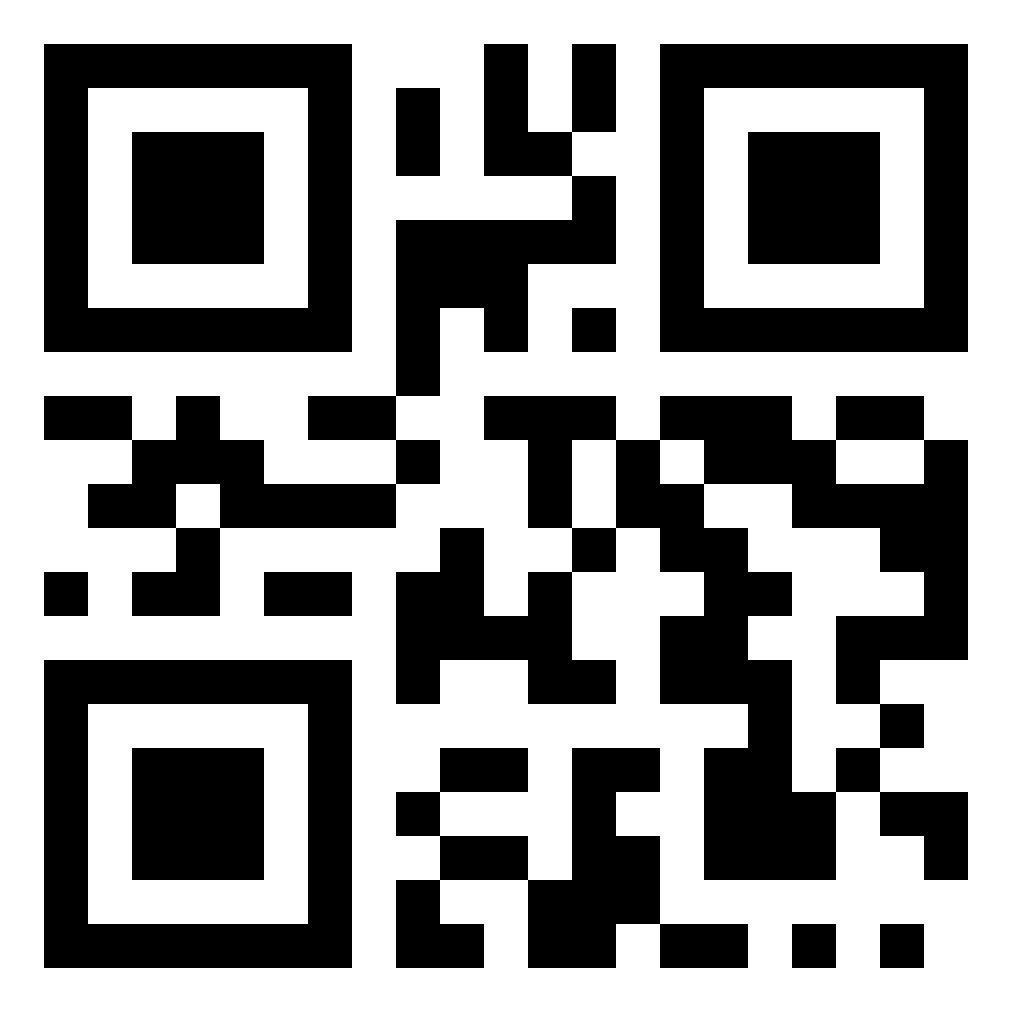

In [ ]:
imgafterpreproc=img
while(rotationflag or bluredflag or inversionflag or mostlywhiteflag or shiftedrowsflag or mostlyblackflag or skewedflag or unwarpedflag or periodicflag or flipflag or SaltandPepper ):
    if(inversionflag == True):
        imgafterpreproc=invert_image(imgafterpreproc)

    if(rotationflag==True):
        imgafterpreproc= a3dlrotation(imgafterpreproc)

    if(bluredflag==True):
        imgafterpreproc= nadafblured(imgafterpreproc)

    if(shiftedrowsflag==True):
        imgafterpreproc = solve_shifted_rows(imgafterpreproc)

    if(mostlywhiteflag==True):
        imgafterpreproc=edit_white_img(imgafterpreproc)

    if(periodicflag==True):
        imgafterpreproc=periodicnoiseSolver(imgafterpreproc)

    if(mostlyblackflag==True):
        imgafterpreproc=dalma(imgafterpreproc)

    if(skewedflag ==True):
        imgafterpreproc=orientSkewness(imgafterpreproc)

    if(unwarpedflag ==True):
        _,thresh = cv2.threshold(imgafterpreproc, 128, 255, cv2.THRESH_BINARY)
        imgafterpreproc=unwarped(imgafterpreproc,thresh)

    if(flipflag == True):
        imgafterpreproc=flip(imgafterpreproc)

    if(SaltandPepper ==True):
        imgafterpreproc=denoiseSaltPepper(imgafterpreproc)


    rotationflag= checkrotation(imgafterpreproc)

    SaltandPepper = detect_patterns_in_roi(imgafterpreproc)

    bluredflag = checkblured(imgafterpreproc)

    shiftedrowsflag= detect_shift_rows(imgafterpreproc)

    mostlywhiteflag= is_mostly_white(imgafterpreproc)

    skewedflag,unwarpedflag = checkskew(imgafterpreproc)

    periodicflag=detect_periodic_noise(imgafterpreproc)

    mostlyblackflag=is_mostly_black(imgafterpreproc)

    inversionflag=inversioncheck(imgafterpreproc)

    flipflag=checkflip(imgafterpreproc)




cv2_imshow(imgafterpreproc)

# **Reshape** hy5osh 3ala decode

shape: (924, 924)
48
1008


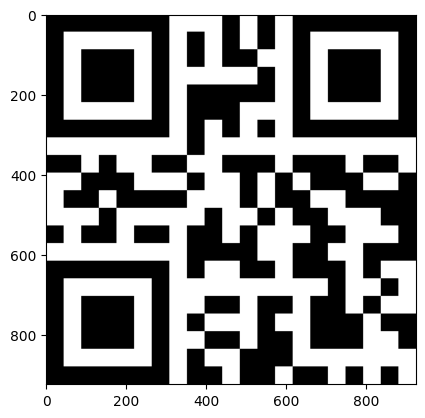

In [ ]:
_, thresh = cv2.threshold(imgafterpreproc, 142, 255, cv2.THRESH_BINARY)
imgremove= remove_quietnoise(thresh)
plt.imshow(imgremove,cmap='gray')
print("shape:",imgremove.shape)
if(imgremove.shape[0]<imgremove.shape[1]):
    num_rows = abs(imgremove.shape[1] - imgremove.shape[0])
    num_cols = imgremove.shape[1]
    my_array = np.ones((num_rows, num_cols))
    imgremove = np.concatenate((my_array, imgremove))

if(imgremove.shape[0]>imgremove.shape[1]):
    num_rows =  imgremove.shape[0]
    num_cols = abs(imgremove.shape[1] - imgremove.shape[0])
    my_array = np.ones((num_rows, num_cols))
    print(my_array.shape)
    imgremove = np.hstack((my_array, imgremove))
plt.imshow(imgremove,cmap='gray')

grid_cells_num=21
cell_sizex,cell_sizey= [int(x) // grid_cells_num for x in img.shape]
if(cell_sizex<cell_sizey):
    grid_cell_size=cell_sizey

else:
    grid_cell_size= cell_sizex

print(grid_cell_size)

qr_cells= getqrcell(imgremove,grid_cell_size,grid_cells_num)
# _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
# for i, row in enumerate(axes):
#     for j, col in enumerate(row):
#         col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
#         col.get_xaxis().set_visible(False)
#         col.get_yaxis().set_visible(False)
#         col.spines[:].set_color('red')

# Decode

In [ ]:
def change_binary(qr_cell,grid_cell_num):
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    return qr_cells_numeric

In [ ]:
qr_cells_numeric=change_binary(qr_cells,grid_cells_num)


MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}


def getecldown(qr_cells_numeric):
    qr_cells_numeric[-1][8]

    ecl = [int(not(c)) for c in qr_cells_numeric[-1:-3:-1, 8]]
    # Why "not"? Because the standard uses '1's for black and '0's for white
    #
    # "A dark module is a binary one and a light module is a binary zero."
    #  - ISO/IEC 18004:2000(E)
    #
    # In image processing, we use them the other way.. Hence the inversion
    return ecl

def get_maskdown(qr_cells_numeric):
    # Dictionary of all masks and their equivalent formulae
    # Same row as above, the three cells after the ecl cells (converted to a string)
    mask = [int(not(c)) for c in qr_cells_numeric[-3:-6:-1,8]]
    mask_str = ''.join([str(c) for c in mask])
    return mask,mask_str

def get_fecdown(qr_cells_numeric):
    fec = []
    fec.extend(qr_cells_numeric[-6:-8:-1, 8])
    # fec.append(qr_cells_numeric[8, 8])
    fec.extend(qr_cells_numeric[0:6, 8])
    fec.extend(qr_cells_numeric[7:9, 8])
    fec = [int(not(c)) for c in fec]
    return fec

print(getecldown(qr_cells_numeric))
print(get_maskdown(qr_cells_numeric))
print(get_fecdown(qr_cells_numeric))
def showneededpixel(qr_cells_numeric):
   _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
   for i, row in enumerate(axes):
       for j, col in enumerate(row):

            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
            if (i == 8 and j <= 8) or (i <= 8 and j == 8):
                if (i != 6) and (j != 6):
                    col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                    col.spines[:].set_color('red')
                    continue
            col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)

[1, 1]
([0, 1, 0], '010')
[0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


In [ ]:
def makeinfo(ecl,mask,fec):
    ecl[0] ^= 1
    mask[0] ^= 1
    mask[2] ^= 1
    fec[5] ^= 1
    fec[8] ^= 1
mask,mask_str=get_maskdown(qr_cells_numeric)
ecl=getecldown(qr_cells_numeric)
fec=get_fecdown(qr_cells_numeric)
makeinfo(ecl,mask,fec)




# lw bayz

In [ ]:
if (is_mostly_black(img)):
  qr_cells_numeric = cv2.resize(imgremove, (21, 21), interpolation=cv2.INTER_AREA) // 255
print(is_mostly_black(img))
qr_cells_numeric_inv = 1 - qr_cells_numeric
UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)
print(qr_cells_numeric.shape)

False
(21, 21)


In [ ]:
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [ ]:
ecl = qr_cells_numeric_inv[-1:-3:-1, 8]
mask = qr_cells_numeric_inv[-3:-6:-1,8]
print("ecl: ",ecl)
print("mask: ",mask)
len_bits = apply_mask_general(21-3, 21-1, qr_cells_numeric_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'{len_bits} = {len_int} data symbols, each consisting of 8 bits')
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

enc_bits = apply_mask_general(21-1, 21-1, qr_cells_numeric_inv, mask, UP4)
print("encc",enc_bits)
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
if enc_bits==[0, 1, 0, 0]:
  # 0100	Byte encoding (8 bits per character)
  print(f'{enc_bits} = Byte encoding (8 bits per character)')
  # First, let's read the data bytes, starting from the very first byte after enc and len
  byte_index = 0
  for _ in range(len_int):
      start_i, start_j, dir = block_starting_indices[byte_index]
      bits = apply_mask_general(start_i, start_j, qr_cells_numeric_inv, mask, dir)
      message_bits.extend(bits)
      bit_string = ''.join([str(bit) for bit in bits])
      alpha_char = chr(int(bit_string, 2))
      print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
      byte_index += 1
  # After finishing all the characters, the next 4 bits are expected to be '0000'
  start_i, start_j, dir = block_starting_indices[byte_index]
  bits = apply_mask_general(start_i, start_j, qr_cells_numeric_inv, mask, dir)
  message_bits.extend(bits)
  bit_string = ''.join([str(bit) for bit in bits])
  print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
  byte_index += 1
  # Let's see what the bytes that follow look like
  # There supposedly remain 25-len-1 bytes to be read
  for _ in range(25 - len_int - 1):
      start_i, start_j, dir = block_starting_indices[byte_index]
      bits = apply_mask_general(start_i, start_j, qr_cells_numeric_inv, mask, dir)
      message_bits.extend(bits)
      bit_string = ''.join([str(bit) for bit in bits])
      alpha_char = chr(int(bit_string, 2))
      print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
      byte_index += 1

elif enc_bits==[0, 0, 1, 0]:

  alpha_eleven=[]
  # 0010	Alphanumeric encoding (11 bits per 2 characters)
  print(f'{enc_bits} = Alphanumeric encoding (11 bits per 2 characters)')
  byte_index = 0
  for _ in range(len_int):
      start_i, start_j, dir = block_starting_indices[byte_index]
      bits = apply_mask_general(start_i, start_j, qr_cells_numeric_inv, mask, dir)
      message_bits.extend(bits)

  for i in range(12, len(message_bits), 11):
      # Take 11 elements starting from the current index
      alpha_two_char = message_bits[i:i+11]
      # Append the chunk to the list of chunks
      alpha_eleven.append(alpha_two_char)
  print(alpha_eleven)
  print(len(alpha_eleven))
  print('message_bits:',message_bits)
  print('message_bits:',len(message_bits))
  alphanumeric_table = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: ' ', 37: '$', 38: '%', 39: '*',
    40: '+', 41: '-', 42: '.', 43: '/', 44: ':'
    }
  alpha_list=[]
  for sublist in alpha_eleven:
    binary_string = ''.join([str(bit) for bit in sublist])
    # print (binary_string)
    decimal_value = int(binary_string, 2)
    # print(decimal_value)
    # Get the first alphanumeric character
    first_char_value = decimal_value // 45
    first_char = alphanumeric_table[first_char_value]

    # Get the second alphanumeric character
    second_char_value = decimal_value % 45
    second_char = alphanumeric_table[second_char_value]

    # Concatenate the characters to form the alphanumeric string
    alphanumeric_string = first_char + second_char
    alpha_list.append(alphanumeric_string)

    print(f"Binary: {binary_string}")
    print(f"Decimal Value: {decimal_value}")
    print(f"Alphanumeric String: {alphanumeric_string}")








ecl:  [1 1]
mask:  [0 1 0]
[0, 0, 0, 0, 1, 1, 0, 0] = 12 data symbols, each consisting of 8 bits
encc [0, 1, 0, 0]
[0, 1, 0, 0] = Byte encoding (8 bits per character)
00110000 (=048) = 0
00110001 (=049) = 1
00101101 (=045) = -
01000111 (=071) = G
01101111 (=111) = o
01101111 (=111) = o
01100100 (=100) = d
00100000 (=032) =  
01101010 (=106) = j
01101111 (=111) = o
01100010 (=098) = b
00100001 (=033) = !
00001110 (=END) -- the NULL TERMINATOR, followed by padding and/or ECC
11000001 (=193) = Á
00011110 (=030) = 
11000001 (=193) = Á
00011110 (=030) = 
1100 (=012) = 
01000011 (=067) = C
00100111 (=039) = '
01011111 (=095) = _
00111011 (=059) = ;
11110011 (=243) = ó
10010001 (=145) = 
10011000 (=152) = 


In [ ]:
# For every 8 bits in the extracted message, convert to a byte
message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

# Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
rsc = rs.RSCodec(nsym=7)

# Decode the bytes with the 7-ECC RS Codec
message_decoded = rsc.decode(message_bytes)
rsc.maxerrata(verbose=True)

# In order to extract the actual data, need to convert back to bits
# Then take as many bytes as indicated by the message length indicator
# That is AFTER removing the first 12 bytes (of enc and len)
data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]

# Now convert back to bytes and print it lol
data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')

This codec can correct up to 3 errors and 7 erasures independently
Data in message = "01-Good job!"


# 7agat 3maltelha comment


In [ ]:
# def get_mask(qr_cells_numeric):
#     # Dictionary of all masks and their equivalent formulae
#     # Same row as above, the three cells after the ecl cells (converted to a string)
#     mask = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
#     mask_str = ''.join([str(c) for c in mask])
#     print(mask)
#     return mask,mask_str

# def get_fec(qr_cells_numeric):
#     fec = []
#     fec.append(qr_cells_numeric[8, 5])
#     fec.append(qr_cells_numeric[8, 7])
#     fec.extend(qr_cells_numeric[0:6, 8])
#     fec.extend(qr_cells_numeric[7:9, 8])
#     fec = [int(not(c)) for c in fec]
#     return fec
# def apply_mask(data_start_i, data_start_j, direction):
#     '''
#     data_start_i/j represent the first cell's coords in its respective direction
#     direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
#     '''
#     result = []
#     row_offsets = []
#     col_offsets = []
#     if (direction in [UP, UP_ENC]):
#         row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
#         col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
#     if (direction == DOWN):
#         row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
#         col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
#     if (direction == CW):
#         row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
#         col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
#     if (direction == CCW):
#         row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
#         col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

#     for i, j in zip(row_offsets, col_offsets):
#         cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
#         result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

#     return result[:4] if direction == UP_ENC else result

# enc_bits = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
# enc_int = int(''.join([str(bit) for bit in enc_bits]), 2)
# print(f'{enc_bits} = Byte encoding (8 bits per character)')

# len_bits = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
# len_int = int(''.join([str(bit) for bit in len_bits]), 2)
# print(f'{len_bits} = {len_int} data symbols, each consisting of 8 bits')

# data_starting_indices = [
# [grid_cells_num-7, grid_cells_num-1, UP],
# [grid_cells_num-11, grid_cells_num-1, CCW],
# [grid_cells_num-10, grid_cells_num-3, DOWN],
# [grid_cells_num-6, grid_cells_num-3, DOWN],
# [grid_cells_num-2, grid_cells_num-3, CW],
# [grid_cells_num-3, grid_cells_num-5, UP],
# [grid_cells_num-7, grid_cells_num-5, UP],
# [grid_cells_num-11, grid_cells_num-5, CCW],
# [grid_cells_num-10, grid_cells_num-7, DOWN],
# [grid_cells_num-6, grid_cells_num-7, DOWN],
# [grid_cells_num-2, grid_cells_num-7, CW],
# [grid_cells_num-3, grid_cells_num-9, UP],
# [grid_cells_num-7, grid_cells_num-9, UP],
# [grid_cells_num-11, grid_cells_num-9, UP],
# [grid_cells_num-16, grid_cells_num-9, UP],
# [grid_cells_num-20, grid_cells_num-9, CCW],
# [grid_cells_num-19, grid_cells_num-11, DOWN],
# [grid_cells_num-14, grid_cells_num-11, DOWN],
# [grid_cells_num-10, grid_cells_num-11, DOWN],
# [grid_cells_num-6, grid_cells_num-11, DOWN],
# # Hmm..? I actually don't know how to proceed now lol
# ]

# message_bits = []
# message_bits.extend(enc_bits)
# message_bits.extend(len_bits)
# extracted_data_no_error_correction = ''
# for a, b, d in data_starting_indices:  # For each starting index and direction
#     bits = apply_mask(a, b, d)  # Extract the bits per the indexed QR code symbol
#     bit_string = ''.join([str(bit) for bit in bits])  # Convert to string of bits
#     alpha_char = chr(int(bit_string, 2))  # Convert binary to int, then to a char
#     if bit_string[:4] == "0000":  # If the first 4 bits are 0s, this is the END
#         print(f'{bit_string[:4]}...         = NULL TERMINATOR (END Symbol, SKIP!)')
#         message_bits.extend(bits[:4])  # Append only the four bits
#         break
#     else:  # If not the END symbol, append full set of bits
#         message_bits.extend(bits)
#         extracted_data_no_error_correction += alpha_char
#     print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')

# print(f'\ni.e., the data and ECCs in the QR code as-is are "{extracted_data_no_error_correction}"')